In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import roc_auc_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [3]:
from jupyterthemes import jtplot

In [4]:
jtplot.style()

In [5]:
bike_rentals = pd.read_csv('bike_rental_hour.csv')

In [6]:
print(bike_rentals.info())
bike_rentals.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 17 columns):
instant       17379 non-null int64
dteday        17379 non-null object
season        17379 non-null int64
yr            17379 non-null int64
mnth          17379 non-null int64
hr            17379 non-null int64
holiday       17379 non-null int64
weekday       17379 non-null int64
workingday    17379 non-null int64
weathersit    17379 non-null int64
temp          17379 non-null float64
atemp         17379 non-null float64
hum           17379 non-null float64
windspeed     17379 non-null float64
casual        17379 non-null int64
registered    17379 non-null int64
cnt           17379 non-null int64
dtypes: float64(4), int64(12), object(1)
memory usage: 2.3+ MB
None


,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


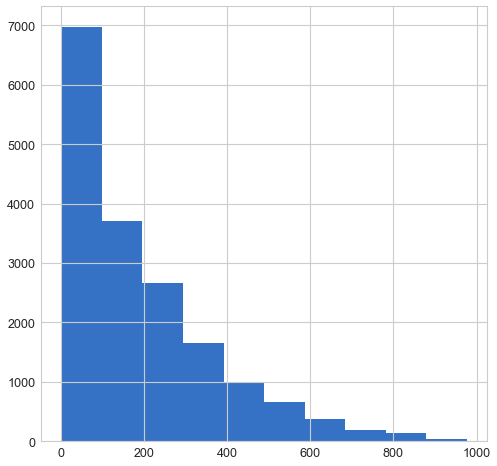

In [7]:
plt.figure(figsize=(8,8))
bike_rentals['cnt'].hist()

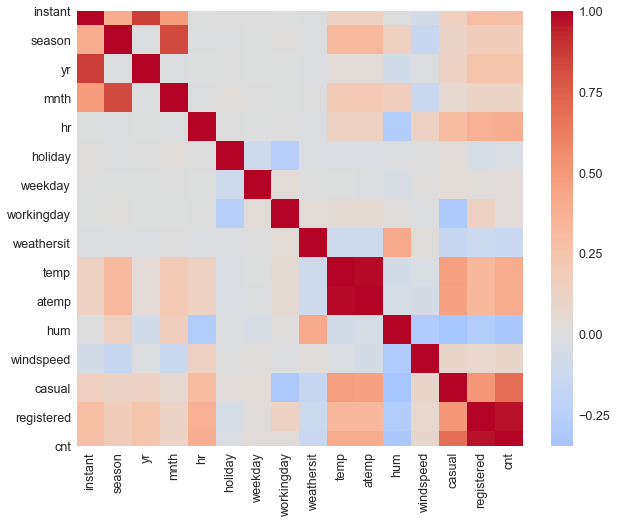

In [8]:
plt.figure(figsize=(10,8))
sns.heatmap(bike_rentals.corr(), cmap='coolwarm', center=0)

In [9]:
def assign_label(hour):
    chunk = 0
    if hour in range(6,13):
        chunk = 1
    elif hour in range(12,19):
        chunk = 2
    elif hour in range(18,25):
        chunk = 3
    else:
        chunk = 4
    return chunk

In [10]:
bike_rentals['time_label'] = bike_rentals['hr'].apply(assign_label)

In [11]:
cnt_corr = bike_rentals.corr()['cnt']
top_vals = cnt_corr[np.abs(cnt_corr.values) >= 0.15].abs().sort_values(ascending=False)
print(top_vals)

features = top_vals.drop(['cnt','registered','casual','temp','hr','season','hum','yr']).index
features2 = top_vals.drop(['cnt','registered','casual','temp','hr','hum','yr']).index
features3 = bike_rentals.drop(columns=['cnt','registered','casual','dteday']).columns

cnt           1.000000
registered    0.972151
casual        0.694564
time_label    0.427632
temp          0.404772
atemp         0.400929
hr            0.394071
hum           0.322911
instant       0.278379
yr            0.250495
season        0.178056
Name: cnt, dtype: float64


In [12]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error as mser
from sklearn.metrics import mean_absolute_error as maer

In [40]:
observations = int(np.floor(len(bike_rentals)*0.7))
np.random.seed(5)
index_perm = np.random.permutation(bike_rentals.index)
bike_rentals = bike_rentals.loc[index_perm]

train = bike_rentals.iloc[:observations]
test = bike_rentals.iloc[observations:]

In [14]:
lr = LinearRegression()
lr.fit(train[features], train['cnt'])
linear_prediction = lr.predict(test[features])
mse = mser(test['cnt'], linear_prediction)
mae = maer(test['cnt'], linear_prediction)
print('Root Mean Squared Error: {:.2f} \nMean Absolute Error: {:.2f}'.format(mse**0.5, mae))

Root Mean Squared Error: 142.13 
Mean Absolute Error: 106.73


Comparing the rmse of 145 on this linear regression with the histogram above it's clear the model doesn't perform well. The mae of 108 looks better, and considering the highly right-skewed distribution is probably a better measure of performance.

Looking at the output from the cell below we see the mean of 189.5 and median of 142 so regardless of the error metric the linear model is still way off.

In [15]:
bike_rentals['cnt'].describe()

count    17379.000000
mean       189.463088
std        181.387599
min          1.000000
25%         40.000000
50%        142.000000
75%        281.000000
max        977.000000
Name: cnt, dtype: float64

In [16]:
clf = DecisionTreeRegressor()
clf.fit(train[features], train['cnt'])
dtree1_pred = clf.predict(test[features])

dtree1_mse = mser(test['cnt'], dtree1_pred)
dtree1_mae = maer(test['cnt'], dtree1_pred)

print('RMSE: {:.2f} \nMAE:  {:.2f}'.format(np.sqrt(dtree1_mse),
                                         dtree1_mae))

RMSE: 132.52 
MAE:  83.50


In [17]:
clf = DecisionTreeRegressor(min_samples_leaf = 2, random_state=5)
clf.fit(train[features], train['cnt'])
dtree1_pred = clf.predict(test[features])

dtree1_mse = mser(test['cnt'], dtree1_pred)
dtree1_mae = maer(test['cnt'], dtree1_pred)

print('RMSE: {:.2f} \nMAE:  {:.2f}'.format(np.sqrt(dtree1_mse),
                                         dtree1_mae))

RMSE: 126.91 
MAE:  81.87


In [18]:
for i in range(4,12,2):
    for j in range(5, 100, 10):
        clf = DecisionTreeRegressor(min_samples_leaf = j, max_depth = 12-i, random_state=5)
        clf.fit(train[features], train['cnt'])
        dtree1_pred = clf.predict(test[features])

        dtree1_mse = mser(test['cnt'], dtree1_pred)
        dtree1_mae = maer(test['cnt'], dtree1_pred)

        print('max_depth: {} \t min_sample_leaf: {}'.format(12-i, j))
        print('RMSE: {:.2f} \nMAE:  {:.2f}'.format(np.sqrt(dtree1_mse),
                                                 dtree1_mae))

max_depth: 8 	 min_sample_leaf: 5
RMSE: 118.47 
MAE:  82.63
max_depth: 8 	 min_sample_leaf: 15
RMSE: 118.37 
MAE:  82.76
max_depth: 8 	 min_sample_leaf: 25
RMSE: 118.16 
MAE:  82.68
max_depth: 8 	 min_sample_leaf: 35
RMSE: 117.94 
MAE:  82.46
max_depth: 8 	 min_sample_leaf: 45
RMSE: 117.91 
MAE:  82.50
max_depth: 8 	 min_sample_leaf: 55
RMSE: 118.11 
MAE:  82.54
max_depth: 8 	 min_sample_leaf: 65
RMSE: 117.70 
MAE:  82.52
max_depth: 8 	 min_sample_leaf: 75
RMSE: 117.92 
MAE:  82.61
max_depth: 8 	 min_sample_leaf: 85
RMSE: 118.40 
MAE:  82.79
max_depth: 8 	 min_sample_leaf: 95
RMSE: 118.51 
MAE:  83.17
max_depth: 6 	 min_sample_leaf: 5
RMSE: 119.10 
MAE:  83.77
max_depth: 6 	 min_sample_leaf: 15
RMSE: 119.15 
MAE:  83.81
max_depth: 6 	 min_sample_leaf: 25
RMSE: 119.16 
MAE:  83.81
max_depth: 6 	 min_sample_leaf: 35
RMSE: 119.14 
MAE:  83.78
max_depth: 6 	 min_sample_leaf: 45
RMSE: 119.20 
MAE:  83.90
max_depth: 6 	 min_sample_leaf: 55
RMSE: 119.25 
MAE:  83.95
max_depth: 6 	 min_sample_

In [19]:
clf = RandomForestRegressor(random_state = 5)
clf.fit(train[features], train['cnt'])
rf_pred = clf.predict(test[features])
rmse = np.sqrt(mser(test['cnt'], rf_pred))
mae = maer(test['cnt'], rf_pred)

print("RMSE: {:.2f}\nMAE: {:.2f}".format(rmse, mae))

C:\Users\isaac\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RMSE: 114.86
MAE: 74.86


In [20]:
for j in range(3, 11):
    for i in range(5, 30, 10):
        clf = RandomForestRegressor(n_estimators = 15, random_state = 5, min_samples_leaf = i, max_depth=j)
        clf.fit(train[features], train['cnt'])
        rf_pred = clf.predict(test[features])
        rmse = np.sqrt(mser(test['cnt'], rf_pred))
        mae = maer(test['cnt'], rf_pred)
        
        print("max_depth: {}".format(j))
        print("\tmin_samples_leaf: " + str(i))
        print("\tRMSE: {:.2f}\n\tMAE: {:.2f} \n".format(rmse, mae))

max_depth: 3
	min_samples_leaf: 5
	RMSE: 130.80
	MAE: 92.67 

max_depth: 3
	min_samples_leaf: 15
	RMSE: 130.80
	MAE: 92.67 

max_depth: 3
	min_samples_leaf: 25
	RMSE: 130.80
	MAE: 92.67 

max_depth: 4
	min_samples_leaf: 5
	RMSE: 125.42
	MAE: 88.83 

max_depth: 4
	min_samples_leaf: 15
	RMSE: 125.42
	MAE: 88.83 

max_depth: 4
	min_samples_leaf: 25
	RMSE: 125.42
	MAE: 88.83 

max_depth: 5
	min_samples_leaf: 5
	RMSE: 120.05
	MAE: 85.04 

max_depth: 5
	min_samples_leaf: 15
	RMSE: 120.05
	MAE: 85.05 

max_depth: 5
	min_samples_leaf: 25
	RMSE: 120.07
	MAE: 85.08 

max_depth: 6
	min_samples_leaf: 5
	RMSE: 117.46
	MAE: 82.74 

max_depth: 6
	min_samples_leaf: 15
	RMSE: 117.50
	MAE: 82.80 

max_depth: 6
	min_samples_leaf: 25
	RMSE: 117.49
	MAE: 82.78 

max_depth: 7
	min_samples_leaf: 5
	RMSE: 116.89
	MAE: 82.11 

max_depth: 7
	min_samples_leaf: 15
	RMSE: 116.81
	MAE: 82.21 

max_depth: 7
	min_samples_leaf: 25
	RMSE: 116.81
	MAE: 82.22 

max_depth: 8
	min_samples_leaf: 5
	RMSE: 116.53
	MAE: 81.56 

In [21]:
for i in range(10,31,4):
    for j in range(5, 20, 2):
        clf = RandomForestRegressor(n_estimators = i, random_state = 10, max_depth=j)
        clf.fit(train[features], train['cnt'])
        rf_pred = clf.predict(test[features])
        rmse = np.sqrt(mser(test['cnt'], rf_pred))
        mae = maer(test['cnt'], rf_pred)
        
        print("n_estimators: " + str(i))
        print("max_depth: {}".format(j))
    #     print("\tmin_samples_leaf: " + str(i))
        print("\tRMSE: {:.2f}\n\tMAE: {:.2f} \n".format(rmse, mae))

n_estimators: 10
max_depth: 5
	RMSE: 121.01
	MAE: 85.70 

n_estimators: 10
max_depth: 7
	RMSE: 116.77
	MAE: 82.15 

n_estimators: 10
max_depth: 9
	RMSE: 115.26
	MAE: 80.31 

n_estimators: 10
max_depth: 11
	RMSE: 114.06
	MAE: 78.46 

n_estimators: 10
max_depth: 13
	RMSE: 113.40
	MAE: 77.00 

n_estimators: 10
max_depth: 15
	RMSE: 113.36
	MAE: 75.92 

n_estimators: 10
max_depth: 17
	RMSE: 113.29
	MAE: 75.33 

n_estimators: 10
max_depth: 19
	RMSE: 113.48
	MAE: 74.92 

n_estimators: 14
max_depth: 5
	RMSE: 120.81
	MAE: 85.58 

n_estimators: 14
max_depth: 7
	RMSE: 116.76
	MAE: 82.12 

n_estimators: 14
max_depth: 9
	RMSE: 115.24
	MAE: 80.30 

n_estimators: 14
max_depth: 11
	RMSE: 113.73
	MAE: 78.39 

n_estimators: 14
max_depth: 13
	RMSE: 112.99
	MAE: 76.83 

n_estimators: 14
max_depth: 15
	RMSE: 112.51
	MAE: 75.50 

n_estimators: 14
max_depth: 17
	RMSE: 112.50
	MAE: 74.90 

n_estimators: 14
max_depth: 19
	RMSE: 112.57
	MAE: 74.54 

n_estimators: 18
max_depth: 5
	RMSE: 120.92
	MAE: 85.69 

n_es

In [22]:
for i in range(10,31,4):
    for j in range(5, 20, 2):
        clf = RandomForestRegressor(n_estimators = i, random_state = 10, max_depth=j, min_samples_leaf=2)
        clf.fit(train[features3], train['cnt'])
        rf_pred = clf.predict(test[features3])
        rmse = np.sqrt(mser(test['cnt'], rf_pred))
        mae = maer(test['cnt'], rf_pred)
        
        print("n_estimators: " + str(i))
        print("max_depth: {}".format(j))
    #     print("\tmin_samples_leaf: " + str(i))
        print("\tRMSE: {:.2f}\n\tMAE: {:.2f} \n".format(rmse, mae))

n_estimators: 10
max_depth: 5
	RMSE: 105.43
	MAE: 69.66 

n_estimators: 10
max_depth: 7
	RMSE: 76.28
	MAE: 49.09 

n_estimators: 10
max_depth: 9
	RMSE: 55.88
	MAE: 35.69 

n_estimators: 10
max_depth: 11
	RMSE: 47.52
	MAE: 29.64 

n_estimators: 10
max_depth: 13
	RMSE: 43.92
	MAE: 26.96 

n_estimators: 10
max_depth: 15
	RMSE: 42.73
	MAE: 26.19 

n_estimators: 10
max_depth: 17
	RMSE: 42.26
	MAE: 25.74 

n_estimators: 10
max_depth: 19
	RMSE: 42.34
	MAE: 25.74 

n_estimators: 14
max_depth: 5
	RMSE: 104.32
	MAE: 68.93 

n_estimators: 14
max_depth: 7
	RMSE: 74.76
	MAE: 48.30 

n_estimators: 14
max_depth: 9
	RMSE: 55.34
	MAE: 35.45 

n_estimators: 14
max_depth: 11
	RMSE: 46.55
	MAE: 29.15 

n_estimators: 14
max_depth: 13
	RMSE: 42.99
	MAE: 26.53 

n_estimators: 14
max_depth: 15
	RMSE: 41.78
	MAE: 25.73 

n_estimators: 14
max_depth: 17
	RMSE: 41.27
	MAE: 25.34 

n_estimators: 14
max_depth: 19
	RMSE: 41.28
	MAE: 25.26 

n_estimators: 18
max_depth: 5
	RMSE: 104.10
	MAE: 68.76 

n_estimators: 18
m

KeyboardInterrupt: 

In [23]:
clf = RandomForestRegressor(n_estimators = 50, random_state = 10, min_samples_leaf=2)
clf.fit(train[features3], train['cnt'])
rf_pred = clf.predict(test[features3])
rmse = np.sqrt(mser(test['cnt'], rf_pred))
mae = maer(test['cnt'], rf_pred)

print("n_estimators: " + str(100))

#     print("\tmin_samples_leaf: " + str(i))
print("\tRMSE: {:.2f}\n\tMAE: {:.2f} \n".format(rmse, mae))

n_estimators: 100
	RMSE: 40.68
	MAE: 24.85 



In [28]:
pd.Series(clf.feature_importances_, index=features3).sort_values(ascending=False)

hr            0.591295
instant       0.165324
workingday    0.069891
atemp         0.051332
temp          0.043244
hum           0.024878
weathersit    0.015787
time_label    0.012508
weekday       0.012028
windspeed     0.006784
mnth          0.002706
season        0.002275
holiday       0.001865
yr            0.000083
dtype: float64

In [ ]:
bike_rentals[['cnt','registered','casual']].describe()

In [ ]:
bike_rentals['registered'].hist()
bike_rentals['casual'].hist()

In [29]:
clf.estimators_

[DecisionTreeRegressor(criterion='mse', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=2,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       presort=False, random_state=1165313289, splitter='best'),
 DecisionTreeRegressor(criterion='mse', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=2,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       presort=False, random_state=1283169405, splitter='best'),
 DecisionTreeRegressor(criterion='mse', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=2,
                       min_samples_split=2

In [30]:
clf.decision_path(test[features3])

(<5214x332914 sparse matrix of type '<class 'numpy.int64'>'
 	with 3951743 stored elements in Compressed Sparse Row format>,
 array([     0,   6661,  13350,  19969,  26624,  33297,  40008,  46673,
         53356,  60033,  66702,  73423,  80100,  86809,  93464, 100137,
        106806, 113459, 120112, 126707, 133312, 139951, 146592, 153265,
        159898, 166549, 173148, 179817, 186404, 193051, 199646, 206315,
        212966, 219713, 226368, 232967, 239654, 246293, 252946, 259675,
        266312, 272901, 279546, 286237, 292904, 299489, 306202, 312861,
        319578, 326283, 332914], dtype=int32))

In [34]:
bike_rentals['cnt'].describe(percentiles=np.arange(0,1,.2)).iloc[4:]

0%       1.0
20%     27.0
40%     98.0
50%    142.0
60%    189.0
80%    321.0
max    977.0
Name: cnt, dtype: float64

In [35]:
def grouping(count):
    group = 0
    if count in range(1,27):
        group = 1
    elif count in range(27,98):
        group = 2
    elif count in range(98,189):
        group = 3
    elif count in range(189,321):
        group = 4
    else:
        group = 5

In [37]:
bike_rentals['cnt_group'] = bike_rentals['cnt'].apply(grouping)

In [38]:
from sklearn.ensemble import RandomForestClassifier

In [41]:
cll = RandomForestClassifier(n_estimators = 50, random_state = 10, min_samples_leaf=2)
cll.fit(train[features3], train['cnt_group'])
pred_class = cll.predict_proba(test[features3])

ValueError: Unknown label type: 'unknown'